# This Notebook contains code to train mask classifiers the compiled image dataset

Face Analysis
* [Feature Extraction](#feat_ext)
* [Machine Learning Classifiers](#ml) 
* [Deep Learning with Keras](#dl)

Face Analysis with Additional Mask Annotation
* TODO: need to complete this part

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

from mtcnn.mtcnn import MTCNN # TODO: what is this?

# Load in Image Data and Labels from the Compiled Dataset



In [2]:
train = pd.read_csv('compiled_labels_km-annotated.csv')

display(train)



name   x1   x2   y1   y2       classname  \
0        1801.jpg  451  186  444  511    face_no_mask   
1        1802.jpg  160  151  108  114       face_mask   
2        1802.jpg  110   71  163  201  face_with_mask   
3        1803.jpg  147  200  141  120       face_mask   
4        1803.jpg  126   75  177  258  face_with_mask   
...           ...  ...  ...  ...  ...             ...   
20312  new_76.jpg  191  187  282  382    face_no_mask   
20313  new_78.jpg  126  200  335  370    face_no_mask   
20314  new_79.jpg  138  212  305  332    face_no_mask   
20315  new_90.jpg  133  263  346  316    face_no_mask   
20316  new_94.jpg  124  269  334  297    face_no_mask   

                           image_file_dir  
0      ../Dataset/mask_image_data/images/  
1      ../Dataset/mask_image_data/images/  
2      ../Dataset/mask_image_data/images/  
3      ../Dataset/mask_image_data/images/  
4      ../Dataset/mask_image_data/images/  
...                                   ...  
20312       ../Dataset/yolo/images/valid/  
20313       ../Dataset/yolo/images/valid/  
20314       ../Dataset/yolo/images/valid/  
20315       ../Dataset/yolo/images/valid/  
20316       ../Dataset/yolo/images/valid/  

[20317 rows x 7 columns]

# Plot Some Annotations

4432.png has 2 label(s)
7294    ../Dataset/mask_image_data/images/4432.png
7295    ../Dataset/mask_image_data/images/4432.png
Name: image_file_dir, dtype: object
['face_with_mask', 'face_mask']


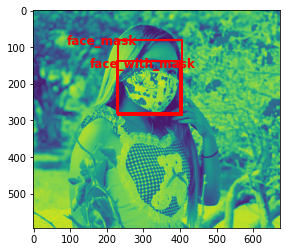

2800.png has 2 label(s)
2673    ../Dataset/mask_image_data/images/2800.png
2674    ../Dataset/mask_image_data/images/2800.png
Name: image_file_dir, dtype: object
['face_mask', 'face_with_mask']


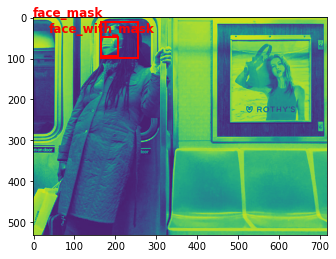

6174.jpg has 1 label(s)
11017    ../Dataset/mask_image_data/images/6174.jpg
Name: image_file_dir, dtype: object
['face_no_mask']


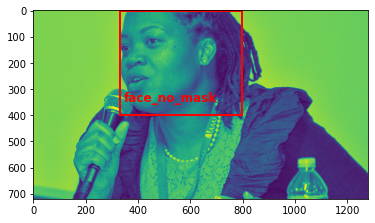

new_155.jpg has 2 label(s)
19727    ../Dataset/yolo/images/train/new_155.jpg
20247    ../Dataset/yolo/images/valid/new_155.jpg
Name: image_file_dir, dtype: object
['face_no_mask', 'face_no_mask']


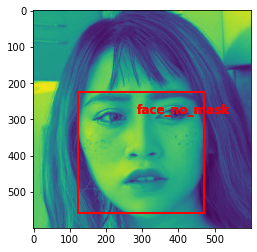

4149.png has 4 label(s)
6478    ../Dataset/mask_image_data/images/4149.png
6479    ../Dataset/mask_image_data/images/4149.png
6480    ../Dataset/mask_image_data/images/4149.png
6481    ../Dataset/mask_image_data/images/4149.png
Name: image_file_dir, dtype: object
['face_mask', 'face_with_mask', 'face_with_mask', 'face_mask']


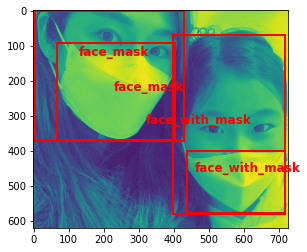

2955.png has 1 label(s)
3072    ../Dataset/mask_image_data/images/2955.png
Name: image_file_dir, dtype: object
['face_other_covering']


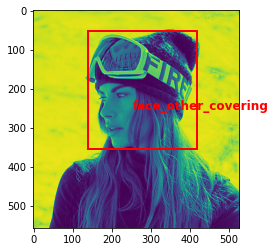

2355.png has 11 label(s)
1531    ../Dataset/mask_image_data/images/2355.png
1532    ../Dataset/mask_image_data/images/2355.png
1533    ../Dataset/mask_image_data/images/2355.png
1534    ../Dataset/mask_image_data/images/2355.png
1535    ../Dataset/mask_image_data/images/2355.png
1536    ../Dataset/mask_image_data/images/2355.png
1537    ../Dataset/mask_image_data/images/2355.png
1538    ../Dataset/mask_image_data/images/2355.png
1539    ../Dataset/mask_image_data/images/2355.png
1540    ../Dataset/mask_image_data/images/2355.png
1541    ../Dataset/mask_image_data/images/2355.png
Name: image_file_dir, dtype: object
['face_with_mask', 'face_with_mask', 'face_with_mask', 'face_with_mask', 'face_no_mask', 'face_mask', 'face_with_mask', 'face_mask', 'face_mask', 'face_mask', 'face_mask']


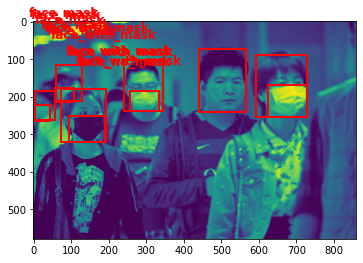

maksssksksss401.png has 4 label(s)
15809    ../Dataset/dataset_4/images/maksssksksss401.png
15810    ../Dataset/dataset_4/images/maksssksksss401.png
15811    ../Dataset/dataset_4/images/maksssksksss401.png
15812    ../Dataset/dataset_4/images/maksssksksss401.png
Name: image_file_dir, dtype: object
['face_no_mask', 'face_no_mask', 'face_with_mask', 'face_with_mask']


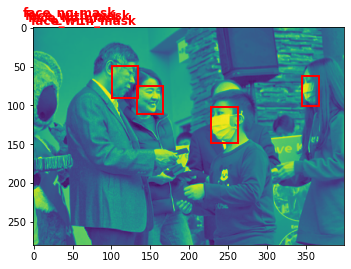

3107.png has 2 label(s)
3430    ../Dataset/mask_image_data/images/3107.png
3431    ../Dataset/mask_image_data/images/3107.png
Name: image_file_dir, dtype: object
['face_mask', 'face_with_mask']


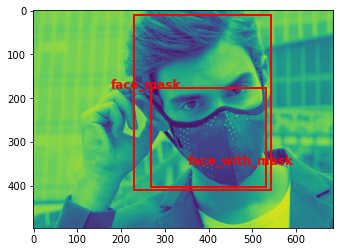

maksssksksss254.png has 7 label(s)
18315    ../Dataset/dataset_4/images/maksssksksss254.png
18316    ../Dataset/dataset_4/images/maksssksksss254.png
18317    ../Dataset/dataset_4/images/maksssksksss254.png
18318    ../Dataset/dataset_4/images/maksssksksss254.png
18319    ../Dataset/dataset_4/images/maksssksksss254.png
18320    ../Dataset/dataset_4/images/maksssksksss254.png
18321    ../Dataset/dataset_4/images/maksssksksss254.png
Name: image_file_dir, dtype: object
['face_no_mask', 'face_with_mask', 'face_with_mask', 'face_with_mask', 'face_with_mask', 'face_no_mask', 'face_with_mask']


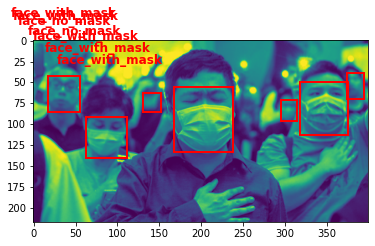

In [3]:
import random
def plot_image_with_all_bboxes(img_nm):
    dat = train[train['name'] == img_nm]
    print(img_nm,"has",len(dat),'label(s)')
    print(dat['image_file_dir']+img_nm)
    
    img = cv2.imread(dat.iloc[0]['image_file_dir']+img_nm,cv2.IMREAD_GRAYSCALE)
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    class_name_ls = []
    for index,row in dat.iterrows():
        rect = patches.Rectangle(
            (row['x1'],row['x2']),
            row['y1'],
            row['y2'],
            linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        ax.text(row['y2']-50, row['y2']-50, row['classname'], fontsize=12,color='r',fontweight='bold')
        class_name_ls.append(row['classname'])
    print(class_name_ls)
    plt.show()
name_ls =list(set(train['name']))
random.shuffle(name_ls)

for f in name_ls[0:10]:
    plot_image_with_all_bboxes(f)
    
    

# TODO: Check for Duplicate Images?


# Plot Distribution of the Labels 

face_with_mask         11767
face_mask               4306
face_no_mask            2872
face_other_covering     1372
Name: classname, dtype: int64


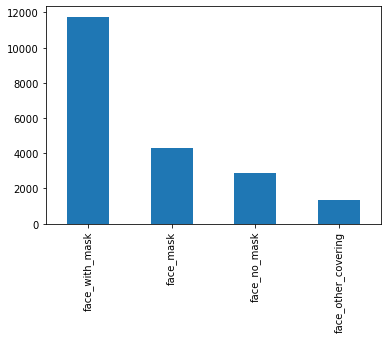

In [4]:
train.classname.value_counts().plot(kind='bar')
print(train.classname.value_counts())


# Get only training data corresponding faces

In [5]:
train = train.reset_index()
train_face = train[train['classname'] != 'face_mask']
# Drop annotations for label face_other_covering
train_face = train_face[train_face['classname']!='face_other_covering']
train_face = train_face.reset_index()
display(train_face)



level_0  index        name   x1   x2   y1   y2       classname  \
0            0      0    1801.jpg  451  186  444  511    face_no_mask   
1            2      2    1802.jpg  110   71  163  201  face_with_mask   
2            4      4    1803.jpg  126   75  177  258  face_with_mask   
3            6      6    1804.jpg  112  113  150  194  face_with_mask   
4            7      7    1805.jpg  728  180  125  156  face_with_mask   
...        ...    ...         ...  ...  ...  ...  ...             ...   
14634    20312  20312  new_76.jpg  191  187  282  382    face_no_mask   
14635    20313  20313  new_78.jpg  126  200  335  370    face_no_mask   
14636    20314  20314  new_79.jpg  138  212  305  332    face_no_mask   
14637    20315  20315  new_90.jpg  133  263  346  316    face_no_mask   
14638    20316  20316  new_94.jpg  124  269  334  297    face_no_mask   

                           image_file_dir  
0      ../Dataset/mask_image_data/images/  
1      ../Dataset/mask_image_data/images/  
2      ../Dataset/mask_image_data/images/  
3      ../Dataset/mask_image_data/images/  
4      ../Dataset/mask_image_data/images/  
...                                   ...  
14634       ../Dataset/yolo/images/valid/  
14635       ../Dataset/yolo/images/valid/  
14636       ../Dataset/yolo/images/valid/  
14637       ../Dataset/yolo/images/valid/  
14638       ../Dataset/yolo/images/valid/  

[14639 rows x 9 columns]

In [6]:
print(set(train_face['classname']))

{'face_no_mask', 'face_with_mask'}


<a id='feat_ext'></a>
# Extract only faces from images
(This may take several minutes to run)

1861.jpg cannot be formatted


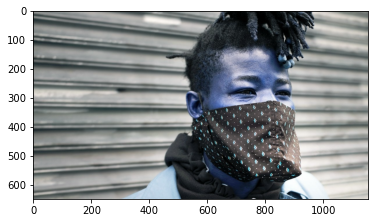

H5B1PXKDL7E4VFI3A2M0.jpg cannot be formatted


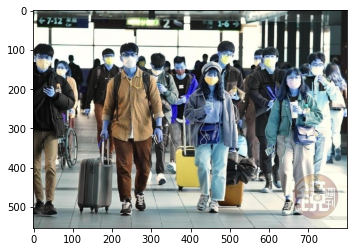

78LGWRXITQB164VPMNF2.jpg cannot be formatted


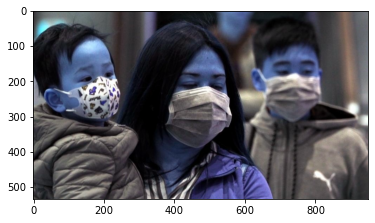

C19GKOAL0N567IMEBWZ3.jpg cannot be formatted


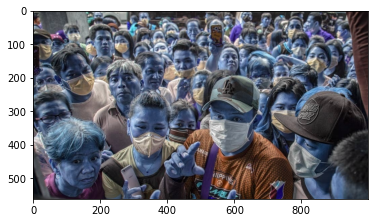

A3RIED7CHW0V8NJ6OUS9.jpg cannot be formatted


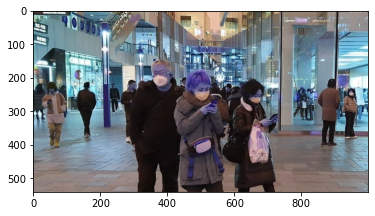

E0HZJ4Y6BDLAIM2PFK3N.jpg cannot be formatted


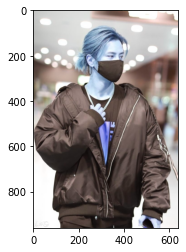

O5RU3HLID1M6J70KP2TX.jpg cannot be formatted


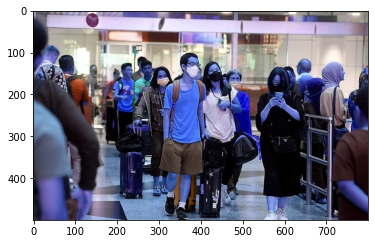

0B2QYGK96UD5S71RTHPX.jpg cannot be formatted


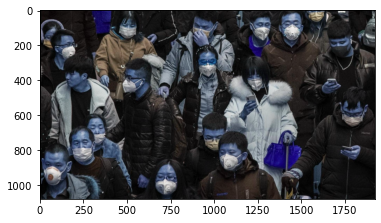

QF9ARXUPKSW7G8410E62.jpg cannot be formatted


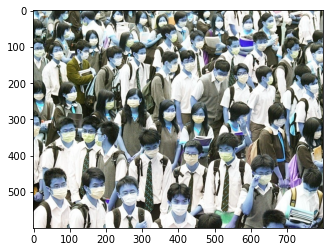

TU02318AD6BE95LMJKX7.jpg cannot be formatted


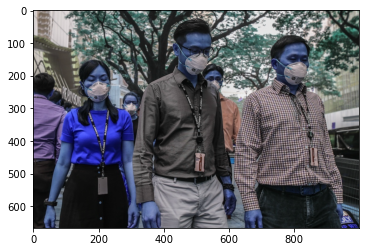

5X3OQU7DKG09S6BCWFE4.jpg cannot be formatted


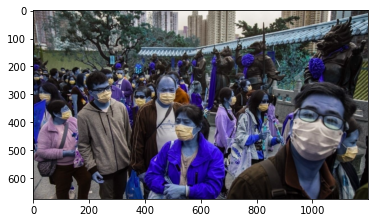

GVCSLM9QR7DOJETNBHZ4.jpg cannot be formatted


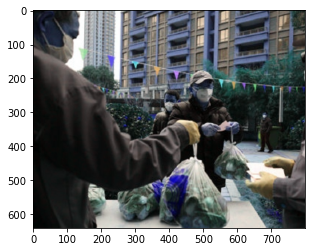

QJULO38P4DGTBNYZ05VR.jpg cannot be formatted


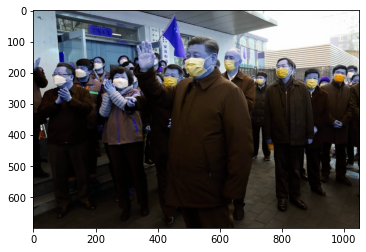

2ETKUNP1937LV84DY65I.jpg cannot be formatted


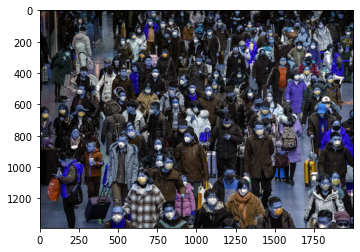

2ETKUNP1937LV84DY65I.jpg cannot be formatted


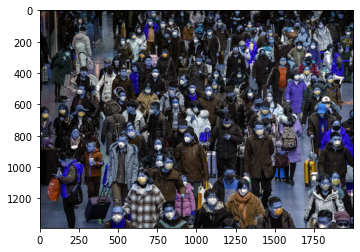

2ETKUNP1937LV84DY65I.jpg cannot be formatted


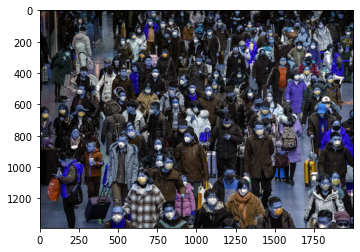

2ETKUNP1937LV84DY65I.jpg cannot be formatted


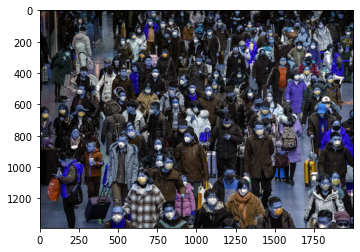

2ETKUNP1937LV84DY65I.jpg cannot be formatted


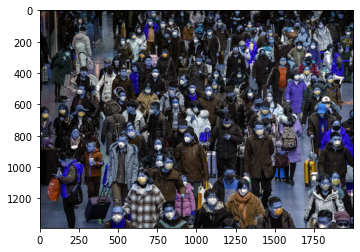

In [7]:
# Extracts images and places the information into a list (data) of 50x50 pixel images
img_size=224#50
data=[]
path="../Dataset/compiled_data/"
to_drop = []
    
for index,row in train_face.iterrows(): # only extract face annotation (NOT mask annotations)
    # reads in the image and converts it to greyscale 
    img_array=cv2.imread(row['image_file_dir']+row['name'],cv2.COLOR_BGR2RGB)#IMREAD_GRAYSCALE)#
    # crops the image to only include the face 
    crop_image = img_array[row['x2']:(row['y2']+row['x2']),
                           row['x1']:(row['y1']+row['x1'])]
    # resizes the image to 50x50
    try:
        new_img_array=cv2.resize(crop_image,(img_size,img_size))
    #         plt.imshow(new_img_array)
    #         plt.show()
        data.append([new_img_array,row['classname']])#new_img_array[1]])
    except:
        print(row['name'],"cannot be formatted")
        plt.imshow(img_array)
        plt.show()
        # keep track of those without the appropriate information and drop from the dataframe
        to_drop.append(index)
        data.append(-1)
    




# Some annotations of small faces cannot be included as we cannot generate a 50x50 image with them so will exclude for now
NOTE: other annotations of these same image files will be retained as they are valuable to our analysis

# Plot Some Extracted Faces
two from each dataset

In [8]:
# get INDICIES of two images from each data source
index_ls = []
for d in list(set(train_face['image_file_dir'])):# will be different for each dataset
    index_ls+=list(train_face[train_face['image_file_dir'] == d].index)[0:2]


[[[69 70 88]
  [55 55 71]
  [67 65 80]
  ...
  [26 22 34]
  [33 29 41]
  [24 20 32]]

 [[64 65 83]
  [68 68 84]
  [77 74 89]
  ...
  [33 29 41]
  [26 22 35]
  [36 32 44]]

 [[67 69 86]
  [66 66 82]
  [72 69 84]
  ...
  [35 31 43]
  [21 17 29]
  [33 29 41]]

 ...

 [[27 26 36]
  [30 30 40]
  [32 31 40]
  ...
  [ 3  2  5]
  [ 3  2  4]
  [ 3  2  4]]

 [[18 17 27]
  [17 16 26]
  [19 18 27]
  ...
  [ 4  3  5]
  [ 2  1  3]
  [ 1  0  2]]

 [[12 11 21]
  [ 9  8 18]
  [12 11 20]
  ...
  [ 5  4  6]
  [ 1  1  2]
  [ 1  1  2]]]
Shape: (224, 224, 3)


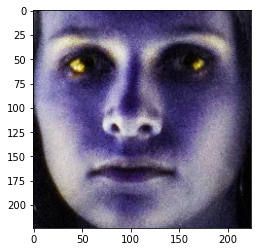


[[[ 32  41  66]
  [ 34  43  69]
  [ 34  45  70]
  ...
  [ 30  48  95]
  [ 31  49  95]
  [ 32  50  94]]

 [[ 32  41  69]
  [ 33  44  71]
  [ 34  45  73]
  ...
  [ 27  46  93]
  [ 30  48  95]
  [ 31  50  95]]

 [[ 33  43  70]
  [ 34  45  72]
  [ 35  47  75]
  ...
  [ 26  46  93]
  [ 28  47  94]
  [ 31  50  95]]

 ...

 [[ 76  87  85]
  [ 74  86  84]
  [ 56  67  69]
  ...
  [122 119 129]
  [130 116 117]
  [140 103  83]]

 [[ 54  62  61]
  [ 67  74  75]
  [ 57  66  68]
  ...
  [112 108 117]
  [121 108 105]
  [142 104  79]]

 [[ 49  57  58]
  [ 61  68  71]
  [ 79  86  89]
  ...
  [104 102 111]
  [114 101  98]
  [138 101  69]]]
Shape: (224, 224, 3)


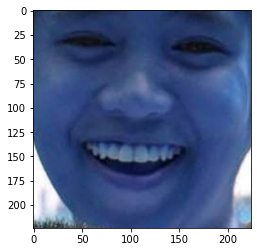


[[[ 76  64  55]
  [ 75  63  53]
  [ 77  65  55]
  ...
  [ 69  62  64]
  [103  96 100]
  [132 125 132]]

 [[ 73  63  53]
  [ 73  63  53]
  [ 76  66  56]
  ...
  [105  97 100]
  [132 125 130]
  [149 142 150]]

 [[ 73  63  53]
  [ 73  63  53]
  [ 73  63  53]
  ...
  [130 122 126]
  [152 144 151]
  [164 156 166]]

 ...

 [[ 59  60  55]
  [ 58  60  55]
  [ 58  61  57]
  ...
  [181 180 190]
  [183 182 192]
  [185 184 194]]

 [[ 66  64  59]
  [ 63  64  59]
  [ 62  65  60]
  ...
  [181 180 190]
  [183 182 192]
  [186 185 195]]

 [[ 72  69  62]
  [ 70  69  62]
  [ 65  68  62]
  ...
  [181 180 190]
  [183 182 192]
  [186 185 195]]]
Shape: (224, 224, 3)


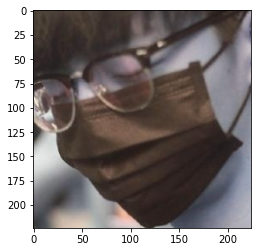


[[[ 20  25  26]
  [ 25  30  31]
  [ 27  32  33]
  ...
  [ 39  44  47]
  [ 42  47  50]
  [ 42  49  51]]

 [[ 32  35  39]
  [ 41  45  46]
  [ 41  45  46]
  ...
  [ 42  46  47]
  [ 45  49  50]
  [ 46  51  52]]

 [[ 49  52  55]
  [ 45  49  50]
  [ 38  42  43]
  ...
  [ 40  45  46]
  [ 46  50  51]
  [ 49  53  54]]

 ...

 [[145 137 137]
  [159 151 151]
  [166 158 158]
  ...
  [134 126 119]
  [134 126 119]
  [131 123 116]]

 [[144 136 136]
  [158 150 150]
  [165 157 157]
  ...
  [133 125 118]
  [134 126 119]
  [131 123 116]]

 [[141 133 131]
  [156 148 148]
  [164 156 157]
  ...
  [133 125 118]
  [134 126 119]
  [131 123 116]]]
Shape: (224, 224, 3)


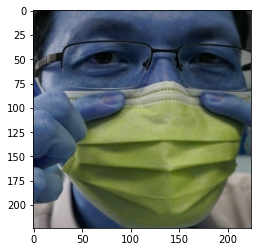


[[[162 158 164]
  [149 145 151]
  [123 120 125]
  ...
  [162 159 165]
  [160 158 164]
  [160 158 164]]

 [[135 131 137]
  [124 120 126]
  [ 80  77  83]
  ...
  [162 159 165]
  [160 158 164]
  [160 158 164]]

 [[153 151 157]
  [ 96  94 100]
  [ 65  62  68]
  ...
  [162 159 165]
  [160 158 164]
  [160 158 164]]

 ...

 [[116 114 120]
  [116 114 120]
  [117 115 121]
  ...
  [ 61  45  46]
  [ 61  45  46]
  [ 54  38  39]]

 [[117 115 121]
  [116 114 120]
  [116 113 119]
  ...
  [ 63  46  47]
  [ 64  47  48]
  [ 62  44  45]]

 [[115 113 119]
  [115 113 119]
  [116 113 120]
  ...
  [ 58  42  43]
  [ 66  49  49]
  [ 67  49  50]]]
Shape: (224, 224, 3)


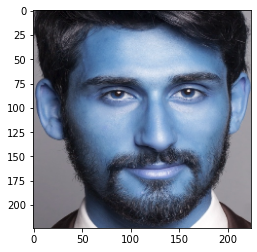


[[[184 234 255]
  [180 232 255]
  [173 227 253]
  ...
  [ 53 113 149]
  [ 47  98 132]
  [ 58 103 136]]

 [[200 244 250]
  [200 246 253]
  [195 244 254]
  ...
  [ 57 113 149]
  [ 52 100 134]
  [ 58 102 133]]

 [[214 251 249]
  [214 253 252]
  [211 253 255]
  ...
  [ 62 114 151]
  [ 58 103 137]
  [ 62 103 135]]

 ...

 [[173 188 213]
  [172 187 210]
  [172 185 207]
  ...
  [129 155 190]
  [122 152 188]
  [118 150 188]]

 [[172 186 205]
  [172 187 206]
  [173 186 205]
  ...
  [129 154 189]
  [122 149 185]
  [117 146 182]]

 [[170 182 200]
  [171 184 202]
  [173 185 204]
  ...
  [129 154 188]
  [121 147 181]
  [113 139 175]]]
Shape: (224, 224, 3)


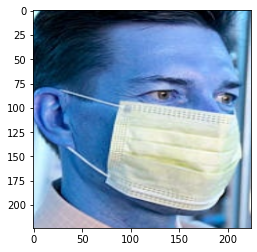


[[[202 222 250]
  [202 222 250]
  [202 222 251]
  ...
  [ 28  36  45]
  [ 29  35  45]
  [ 29  35  45]]

 [[202 222 250]
  [202 222 250]
  [202 223 250]
  ...
  [ 27  34  44]
  [ 28  34  43]
  [ 28  34  43]]

 [[201 222 251]
  [201 222 251]
  [201 223 250]
  ...
  [ 24  31  41]
  [ 26  32  40]
  [ 26  32  40]]

 ...

 [[255 255 254]
  [255 255 254]
  [255 255 254]
  ...
  [ 76  98 124]
  [ 76  98 124]
  [ 76  98 124]]

 [[255 255 254]
  [255 255 254]
  [255 255 254]
  ...
  [ 79 100 126]
  [ 79 101 126]
  [ 79 101 126]]

 [[255 255 254]
  [255 255 254]
  [255 255 254]
  ...
  [ 80 102 127]
  [ 80 102 127]
  [ 80 103 127]]]
Shape: (224, 224, 3)


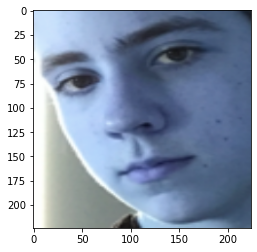


[[[42 52 62]
  [42 52 62]
  [43 53 63]
  ...
  [34 33 37]
  [31 30 34]
  [30 29 32]]

 [[43 52 63]
  [43 53 64]
  [44 53 65]
  ...
  [35 35 40]
  [32 31 35]
  [30 30 33]]

 [[44 53 64]
  [45 54 65]
  [47 55 67]
  ...
  [36 37 45]
  [33 33 38]
  [31 31 35]]

 ...

 [[82 73 68]
  [79 70 65]
  [71 62 57]
  ...
  [44 38 34]
  [48 41 38]
  [49 42 39]]

 [[79 69 65]
  [76 67 62]
  [70 61 56]
  ...
  [43 37 33]
  [46 40 36]
  [48 41 37]]

 [[77 67 63]
  [75 65 61]
  [69 61 56]
  ...
  [42 36 33]
  [45 39 35]
  [47 40 36]]]
Shape: (224, 224, 3)


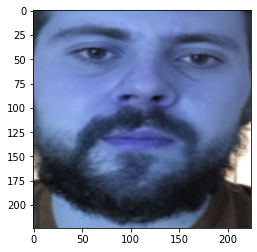


[[[ 32  41  66]
  [ 34  43  69]
  [ 34  45  70]
  ...
  [ 30  48  95]
  [ 31  49  95]
  [ 32  50  94]]

 [[ 32  41  69]
  [ 33  44  71]
  [ 34  45  73]
  ...
  [ 27  46  93]
  [ 30  48  95]
  [ 31  50  95]]

 [[ 33  43  70]
  [ 34  45  72]
  [ 35  47  75]
  ...
  [ 26  46  93]
  [ 28  47  94]
  [ 31  50  95]]

 ...

 [[ 76  87  85]
  [ 74  86  84]
  [ 56  67  69]
  ...
  [122 119 129]
  [130 116 117]
  [140 103  83]]

 [[ 54  62  61]
  [ 67  74  75]
  [ 57  66  68]
  ...
  [112 108 117]
  [121 108 105]
  [142 104  79]]

 [[ 49  57  58]
  [ 61  68  71]
  [ 79  86  89]
  ...
  [104 102 111]
  [114 101  98]
  [138 101  69]]]
Shape: (224, 224, 3)


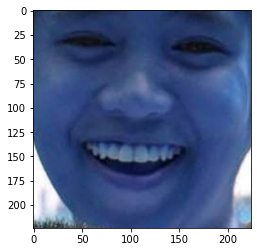


[[[147 167 189]
  [130 158 185]
  [115 151 182]
  ...
  [163 170 189]
  [166 173 192]
  [171 178 197]]

 [[154 173 195]
  [135 164 191]
  [110 147 178]
  ...
  [165 172 191]
  [165 172 191]
  [170 177 195]]

 [[157 177 201]
  [140 169 196]
  [111 145 174]
  ...
  [168 175 194]
  [164 171 190]
  [168 175 194]]

 ...

 [[154 164 174]
  [155 165 175]
  [155 165 175]
  ...
  [ 92 102 127]
  [115 119 138]
  [146 144 158]]

 [[155 164 174]
  [155 165 175]
  [156 166 176]
  ...
  [ 88  97 123]
  [108 113 132]
  [140 139 152]]

 [[155 165 175]
  [156 166 176]
  [156 166 176]
  ...
  [ 85  95 122]
  [104 110 129]
  [135 136 149]]]
Shape: (224, 224, 3)


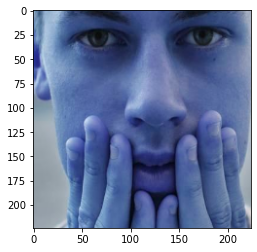

In [9]:
# show a few extracted faces:
for i in index_ls:
    print(data[i][0])
    print("Shape:",data[i][0].shape)
    plt.imshow(data[i][0])
    plt.show()
    print()


# Drop excluded annotations 
Drop elements in data that are -1 
Drop rows in train_face with indicies in to_drop

In [10]:
# Exclude annotations that could not be formatted
train_face = train_face.drop(to_drop)

initial_len = len(data)
data = [x for x in data if x != -1]

print("Dropped",len(to_drop),"images from train_face")
print("Dropped",initial_len-len(data),"faces from data")


Dropped 18 images from train_face
Dropped 18 faces from data


# Extract Labels and Features as x and y
### Convert labels to feature vector of 0's and 1's

In [11]:
# Extracts labels (mask/no mask) and features (50x50 vector of face image) and places them into x and y lists respectively
x=[]
y=[]
for features, labels in data:
    x.append(features)
    y.append(labels)
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
y=lbl.fit_transform(y)
print("y:",y)
print("x:",x[0:5])



y: [0 1 1 ... 0 0 0]
x: [array([[[162, 158, 164],
        [149, 145, 151],
        [123, 120, 125],
        ...,
        [162, 159, 165],
        [160, 158, 164],
        [160, 158, 164]],

       [[135, 131, 137],
        [124, 120, 126],
        [ 80,  77,  83],
        ...,
        [162, 159, 165],
        [160, 158, 164],
        [160, 158, 164]],

       [[153, 151, 157],
        [ 96,  94, 100],
        [ 65,  62,  68],
        ...,
        [162, 159, 165],
        [160, 158, 164],
        [160, 158, 164]],

       ...,

       [[116, 114, 120],
        [116, 114, 120],
        [117, 115, 121],
        ...,
        [ 61,  45,  46],
        [ 61,  45,  46],
        [ 54,  38,  39]],

       [[117, 115, 121],
        [116, 114, 120],
        [116, 113, 119],
        ...,
        [ 63,  46,  47],
        [ 64,  47,  48],
        [ 62,  44,  45]],

       [[115, 113, 119],
        [115, 113, 119],
        [116, 113, 120],
        ...,
        [ 58,  42,  43],
        [ 66,  49,  49],

<a id='split'></a>
### Partition Training set to use part for evaluating (because submission set is unlabelled)

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
sz = 0.2# 0.8 # size of test set partition

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=sz, random_state=42)


print("Full labelled dataset size:",len(x))
print("Splitting data into training/testing set with a "+str(sz*100)+"% partition")
print("Training set size:",len(x_train))
print("Test set size:",len(x_test))




Full labelled dataset size: 14621
Splitting data into training/testing set with a 20.0% partition
Training set size: 11696
Test set size: 2925


<a id='dl'></a>

# Deep learning 

# Using Abdul's methods
[Partition Data](#split)

In [14]:
x_train = np.asarray(x_train)# set of 50x_train50 arrays representing pix_trainel intensities for each image
print("x.shape",x_train.shape)
# x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
print("y:",y_train)

# do same for test dataset
x_test = np.asarray(x_test)
print("\nx_test.shape",x_train.shape)


x.shape (11696, 224, 224, 3)
y: [0 1 1 ... 0 1 1]

x_test.shape (11696, 224, 224, 3)


In [15]:
#normalize the data
x_train = x_train/255.0

# do same for test dataset
x_test = x_test/255.0


In [16]:
y_train = np.array(y_train)
print (y_train.shape)

# do same for test dataset
y_test = np.array(y_test)
print (y_test.shape)


(11696,)
(2925,)


In [18]:
import pickle # module implements binary protocols

pickle_out = open("x_train.pickle",'wb') # "w" - Write - Opens a file for writing, creates the file if it does not ex_trainist . b = binary
pickle.dump(x_train,pickle_out)
print (pickle.dump(x_train,pickle_out))
pickle_out.close



KeyboardInterrupt: 

In [ ]:
pickle_out = open('y_train.pickle','wb')
pickle.dump(y_train,pickle_out)
print (pickle.dump(y_train,pickle_out))
pickle_out.close

In [ ]:
pickle_in = open('x_train.pickle','rb')
x_train = pickle.load(pickle_in)
print(x_train)

pickle_in = open('y_train.pickle','rb')
#y = pickle.load(pickle_in)
y_train = pickle.load(file= pickle_in,  fix_imports=True)
print(y_train)




## Deep learning model for training - Transfer Learning



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [134]:
model = tf.keras.applications.mobilenet.MobileNet() # pre-trained model
#model = tensorflow.keras.applications.mobilenet.MobileNet() # pre-trained model
# to read https://deeplizard.com/learn/video/OO4HD-1wRN8



In [135]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

## Transfer learning

In [136]:
base_input = model.layers[0].input
base_input

<tf.Tensor 'input_4:0' shape=(None, 224, 224, 3) dtype=float32>

In [137]:
base_output = model.layers[-4].output
base_output

<tf.Tensor 'dropout/cond_3/Identity:0' shape=(None, 1, 1, 1024) dtype=float32>

In [138]:
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer) # 0 , 1
final_output = layers.Activation(activation='sigmoid')(final_output) # it was final_ouput 

In [139]:
# I create new model with my new layers 
new_model = keras.Model(inputs = base_input, outputs = final_output)



In [140]:
# I would chek the last layer (sigmoid)
just_to_check = new_model.layers[-1].output
just_to_check



<tf.Tensor 'activation_3/Sigmoid:0' shape=(None, 1) dtype=float32>

In [141]:
new_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

## settings for binary classificaiton (Face mask/without mask)

In [142]:
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])





In [143]:
new_model.fit(x_train,y_train,epochs=1,validation_split= 0.1)
# TODO: remove validation split since we will validate on training or does this use it in the training?




329/329 [==============================] - 758s 2s/step - loss: 0.1086 - accuracy: 0.9606 - val_loss: 0.2588 - val_accuracy: 0.9248


In [144]:
new_model.save('my_model_new_larger_training_set.h5')


## Evaluate model


In [19]:
# load model
new_model = tf.keras.models.load_model('my_model_new_larger_training_set.h5')

In [20]:
# perform prediction
pred = new_model.predict(x=x_test,batch_size=32)



In [23]:
len(y_test)#[:,0])



2925

In [24]:
len([int(round(x,0)) for x in list(pred[:,0])])

2925

### ROC curve 
# ***NOT SURE IF ROC CURVE IS APPLICABLE TO THIS MODEL!!***


ROC curve data saved to: deep_learning_roc_curve.csv

Plot saved to: deep_learning_roc_curve.png


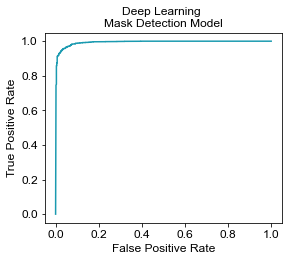

In [49]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, list(pred[:,0]))


### Plot Data ###
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import matplotlib
from matplotlib.gridspec import GridSpec
font = {'weight' : 'normal','size'   : 12,'family'   : "Arial"}
matplotlib.rc('font', **font)
fig = plt.figure()#figsize=(10,6))#(5,3.25))
ax = fig.add_subplot()
plt.plot(
    fpr,
    tpr,
#     '-o',#''.',
    color = '#1a9ab0',
#     label =None,
#     markersize=2,
)
# ax.set_ylim(0.0, 1.05)
ax.set_title("Deep Learning \n"+title,fontsize=12)

# ax.set_xlim(0.0, 1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
fig.set_size_inches(4.25,3.5)

# save roc curve values to csv so can plot with others later
data_file_out="deep_learning_roc_curve.csv"
pd.DataFrame({"fpr":fpr,"tpr":tpr}).to_csv(data_file_out)
print("\nROC curve data saved to:",data_file_out)
             
### Save Figure ###
img_fname = ("deep_learning_roc_curve"+'.png')
plt.savefig('plots/'+img_fname,
            bbox_inches="tight",dpi=300,transparent=True)
print("\nPlot saved to:",img_fname)
             

### Compute Scores

In [118]:
from sklearn import metrics

d = metrics.classification_report(y_test,
                                  [int(round(x,0)) for x in pred],
                                  output_dict = True
                                 )

d = pd.DataFrame(d)
d = d.apply(lambda x: round(x,4))

display(d)




0          1  accuracy  macro avg  weighted avg
precision    0.9920     0.9326    0.9402     0.9623        0.9436
recall       0.6832     0.9987    0.9402     0.8410        0.9402
f1-score     0.8092     0.9645    0.9402     0.8868        0.9357
support    543.0000  2382.0000    0.9402  2925.0000     2925.0000

### Plot Confusion Matrix

In [70]:
pred = list(pred.reshape(2925))

In [71]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,[int(round(x,0)) for x in pred]) # true, predicted

array([[ 371,  172],
       [   3, 2379]])

TN: 371  FP: 172  FN: 3  TP: 2379


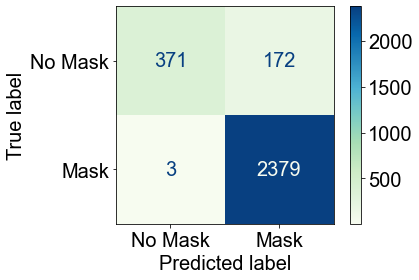

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial" # set default font to Arial
matplotlib.rcParams['font.family'] = "sans-serif" # ALWAYS use sans-serif fonts
matplotlib.rcParams['font.size'] = 20
fig, ax = plt.subplots()

cm = confusion_matrix(y_test,[int(round(x,0)) for x in pred])#pred,y_test[:,0])
tn, fp, fn, tp = cm.ravel()
print("TN:",tn," FP:",fp," FN:",fn," TP:",tp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["No Mask","Mask"])
disp.plot(cmap='GnBu',ax=ax)
title = 'Mask Detection Model'
# ax.set_title('Title')
plt.savefig('plots/'+title.replace(" ","_")+"_confusion_matrix.png",dpi=300,bbox_inches="tight",transparent=True)

